# Growing Neural Gas 

A classical neural network that learns the topologies in data and creates a graph based on the topologies. 

Uses the FeatureGraph (see the repo) for the generic graph features. Clone the FeatureGraph .py files to FeatureGraph subfolder.

In [84]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import os
from IPython.display import clear_output
from sklearn import datasets

from GrowingNeuralGas2 import GrowingNeuralGas
from FeatureGraph.graph import Graph

## Generate dataset

In [86]:
file_path1 = 'C:\ku2022_1\ku2022_16_locopt.csv'
file_path2 = 'C:\ku2022_1\ku2022_16_absproxopt.csv'
file_path3 = 'C:/GNG2/travepoint/ku2022_16_travpoint/ku2022_16_trav_point_grid3.csv'

df1 = pd.read_csv(file_path1)
df2 = pd.read_csv(file_path2)
df3 = pd.read_csv(file_path3)
dataset1 = df1.iloc[:,[2,3]].to_numpy()
dataset2 =  df2.iloc[:,[2,3]].to_numpy()
dataset3 = df3.iloc[:,[1,2]].to_numpy()
#dataset = np.concatenate((pg, prox), axis=0)
#result = pd.concat([pg, prox], axis=1).fillna(0).to_numpy()
#dataset = prox.to_numpy()
#data =np.split(result, 2, axis=1)
#dataset = np.vstack(data)
print(dataset3)


[[ -32 -155]
 [ -31 -150]
 [ -30 -149]
 ...
 [ 125 -145]
 [ 125 -144]
 [ 126 -147]]


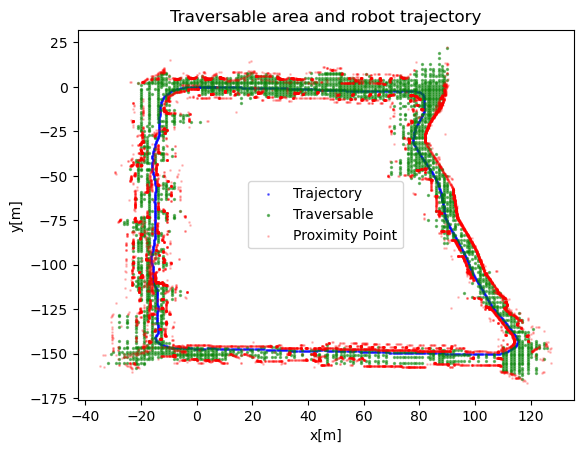

In [87]:
plt.scatter(*dataset1.T, s=1, c='blue', alpha=0.5, label='Trajectory') 
plt.scatter(*dataset3.T, s=2, c='green', alpha=0.5, label='Traversable')
plt.scatter(*dataset2.T, s=1, c='red', alpha=0.2, label='Proximity Point')


plt.title('Traversable area and robot trajectory')        
plt.legend(loc = 'best')
plt.xlabel('x[m]')
plt.ylabel('y[m]')
plt.savefig('C:/GNG2/mapdata/result/ku2022_16/route6_travepoint_grid3.png')
plt.show() 


## Define plotting function for visualizing the graph fitting 

In [91]:

def gng_plotter(dataset1 : np.ndarray, dataset3 : np.ndarray, graph : Graph, iteration : int) -> None: 
        """
        Function to plot the dataset data points and the growing neural gas (GNG) graph. 
        """
        # Get all GNG graph vertex vectors
        vertex_keys = graph.get_vertices()
        vertex_vectors = []
        for key in vertex_keys: 
            vertex_vect = graph.get_vertex_param(key=key, param_key='feature_vector')        
            vertex_vectors.append(vertex_vect)
        vertex_vectors = np.array(vertex_vectors)

        # Get edge end points
        line_points = []
        for key_a in vertex_keys:
            neighbors = graph.get_edges(key_a)['out'] # edges_out 
            vect_a = graph.get_vertex_param(key=key_a, param_key='feature_vector') 
            for key_b in neighbors: 
                vect_b = graph.get_vertex_param(key=key_b, param_key='feature_vector') 
                line_points.append([vect_a, vect_b])

        # Setup image
        clear_output(wait=True) # Clear the previous output in jupyter notebook        
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
        ax.set_aspect('equal')
        
        # Plot dataset points
        #plt.scatter(dataset[:, 0], dataset[:, 1], s=10, c='blue', alpha=0.2, label='Map Data')
        plt.scatter(*dataset1.T, s=1, c='blue', alpha=0.5, label='Trajectory') 
        plt.scatter(*dataset3.T, s=2, c='green', alpha=0.5, label='Traversable')
        plt.scatter(*dataset2.T, s=1, c='red', alpha=0.1, label='Proximity Point')       
        # Plot GNG edges
        for vect_pair in line_points: 
            a_x = vect_pair[0][0]
            a_y = vect_pair[0][1]
            b_x = vect_pair[1][0]
            b_y = vect_pair[1][1]
            plt.plot([a_x, b_x], [a_y, b_y], c='black', alpha=0.5)

        # Plot GNG vertices
        plt.scatter(vertex_vectors[:, 0], vertex_vectors[:, 1], s=3, c='black', alpha=1)

        plt.title('Iteration ' + str(iteration)) 
        plt.xlabel('x[m]')
        plt.ylabel('y[m]')       
        plt.legend(loc = 'best')
    
        if iteration == 100000 :
            plt.savefig('C:/GNG2/mapdata/result/ku2022_16/GNG_Grid4_5')
        plt.show()

        

## Create the Growing Neural Gas graph and fit it to the MAP data

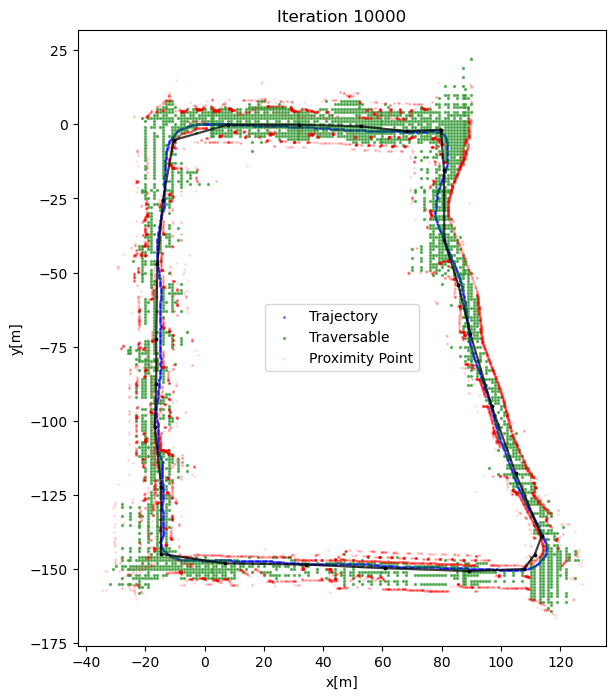

In [92]:
gng = GrowingNeuralGas(feature_dim=2)
gng.fit(dataset1=dataset1,
        dataset2=dataset3, 
        iterations=10000, 
        winner_upd_coeff=0.02,
        neighbor_upd_coeff=0.0005,
        max_vertex=1000, 
        vertex_insert_interval=400,
        vertex_insert_error_scaling=0.5,
        edge_age_limit=30,
        plot_interval=10000,
        plot_function=gng_plotter)

## gng node distribution

In [7]:
vertex_keys = gng.graph.get_vertices()
vertex_vectors = []
for key in vertex_keys: 
    vertex_vect = gng.graph.get_vertex_param(key=key, param_key='feature_vector')        
    vertex_vectors.append(vertex_vect)
vertex_vectors = np.array(vertex_vectors)
print(vertex_vectors.shape)

df = pd.DataFrame(vertex_vectors, columns = ['x', 'y'])
print(df)
df.to_csv('C:/GNG2/mapdata/ku2022_11_gngdistribution_grid3.csv')



(335, 2)
              x           y
0     80.951164  -33.900965
1    112.761447 -135.827466
2    -18.862427  -42.179563
3    -27.641701 -152.536936
4     78.206044 -151.694234
..          ...         ...
330  102.943412 -113.289749
331   59.370348 -149.574866
332   54.845372 -149.110861
333   35.932058   -0.083998
334  -17.174479  -26.663314

[335 rows x 2 columns]


## GNG EDGE INFO

In [9]:
line_points = []
for key_a in vertex_keys:
    neighbors = gng.graph.get_edges(key_a)['out']
    vect_a = gng.graph.get_vertex_param(key=key_a, param_key='feature_vector') 
    for key_b in neighbors: 
        vect_b = gng.graph.get_vertex_param(key=key_b, param_key='feature_vector') 
        line_points.append([vect_a, vect_b])

print(len(line_points))

1006


In [83]:
gng.mean_squared_error

AttributeError: 'GrowingNeuralGas' object has no attribute 'mean_squared_error'

gng.__get_mean_squared_error

In [1]:
total_error = 0

for key in vertex_keys:
    total_error += gng.graph.get_vertex_param(key=key, param_key='error')
mean_squared_error = total_error / gng.n_vertex    

print(mean_squared_error)
#print(total_error)

NameError: name 'vertex_keys' is not defined